# Take-Home Challenge: Relax Inc.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

## Data Loading and Overview

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Wrangling

In [6]:
#Converting dtype of 'time_stamp' to datetime

user_engagement['time_stamp'] = pd.to_datetime(user_engagement.time_stamp)

In [7]:
user_engagement.set_index('time_stamp', inplace=True)
user_engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [8]:
#Let's group by user_id and resample by 7 days

a = user_engagement.groupby('user_id').resample('7D')['visited'].sum()

In [9]:
a.head(20)

user_id  time_stamp
1        2014-04-22    1
2        2013-11-15    1
         2013-11-22    0
         2013-11-29    1
         2013-12-06    1
         2013-12-13    0
         2013-12-20    1
         2013-12-27    1
         2014-01-03    1
         2014-01-10    0
         2014-01-17    0
         2014-01-24    0
         2014-01-31    1
         2014-02-07    3
         2014-02-14    1
         2014-02-21    0
         2014-02-28    0
         2014-03-07    2
         2014-03-14    0
         2014-03-21    0
Name: visited, dtype: int64

**Above we see how many times a user has logged on in a week.**

In [10]:
#Now let's see the max times a user logged on in any week.

x = a.reset_index(level='time_stamp').groupby('user_id')['visited'].max().reset_index()

In [11]:
x.head(10)

,user_id,visited
0,1,1
1,2,3
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,10,7
8,11,1
9,13,1


In [12]:
#Now we make a list of users who logged on 3 or more times in any week 

adopted_users_list = list(x.user_id[x.visited >= 3])

In [13]:
users['adopted_user'] = users['object_id'].apply(lambda x: 1 if x in adopted_users_list else 0)

In [14]:
users.adopted_user.value_counts()

0    10528
1     1472
Name: adopted_user, dtype: int64

In [15]:
print('Number of Adopted Users:', len(adopted_users_list))
print('Number of Total Users:', len(users))
print('Percentage of Adopted Users: {:.2f}%'.format(len(adopted_users_list)/len(users)*100))

Number of Adopted Users: 1472
Number of Total Users: 12000
Percentage of Adopted Users: 12.27%


In [16]:
#Let's convert the dtype of columns 'creation_time' and 'last_session_creation_time' to datetime

users['creation_time'] = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time, unit='s')

In [17]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0


## Exploratory Data Analysis

### Email:

In [18]:
#Extract email domain names

users['email'] = users['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
users['email'] = users['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

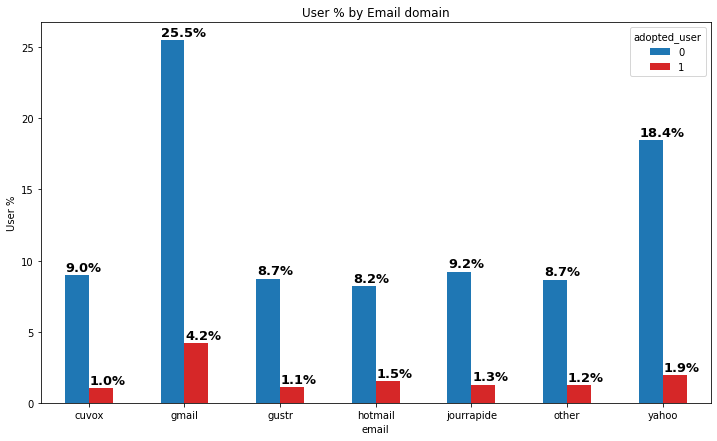

In [19]:
ax = (pd.crosstab(users.email, users.adopted_user)*100/len(users)).plot(kind='bar', 
                                                                            color=('tab:blue','tab:red'), 
                                                                            figsize=(12,7))
plt.title('User % by Email domain')
plt.ylabel('User %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

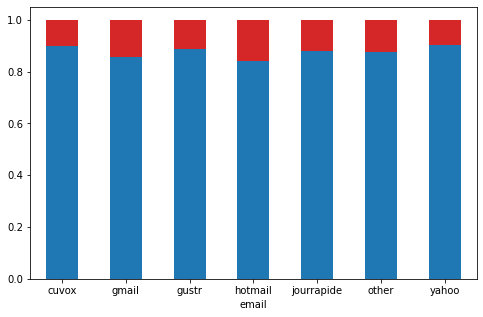

In [20]:
pd.crosstab(users.email, users.adopted_user).apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', 
                                                                                     color=('tab:blue','tab:red'), 
                                                                                     stacked=True, 
                                                                                     figsize=(8,5),
                                                                                     legend=False)
plt.xticks(rotation='horizontal')
plt.show()

- **Users who signed up using hotmail are most likely to become adopted users.**
- **Users who signed up using yahoo or cuvox are less likely to become adopted users.**
- **The difference is very small. This dosen't indicate a adopted user very clearly.**

### Creation Source:

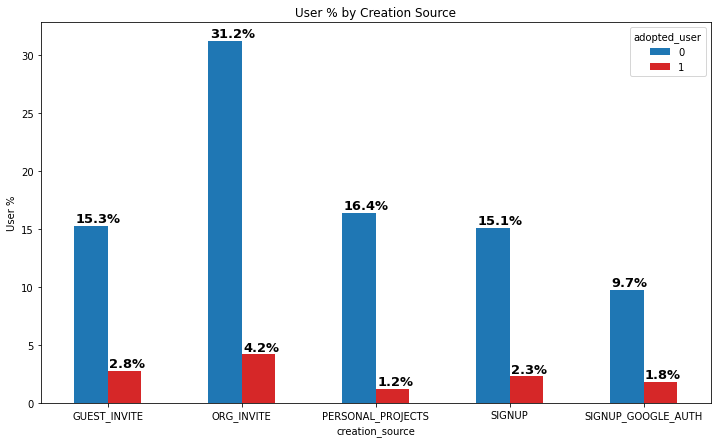

In [21]:
ax = (pd.crosstab(users.creation_source, users.adopted_user)*100/len(users)).plot(kind='bar', 
                                                                            color=('tab:blue','tab:red'), 
                                                                            figsize=(12,7))
plt.title('User % by Creation Source')
plt.ylabel('User %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

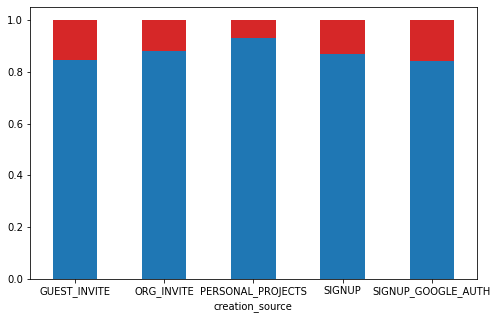

In [22]:
pd.crosstab(users.creation_source, users.adopted_user).apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', 
                                                                                     color=('tab:blue','tab:red'), 
                                                                                     stacked=True, 
                                                                                     figsize=(8,5),
                                                                                     legend=False)
plt.xticks(rotation='horizontal')
plt.show()

- **Users signing up through guest invite or a gmail account are more likely to be adopted.**
- **Users with personal projects are less likely to be an adopted user.**

### Opted to Mailing List:

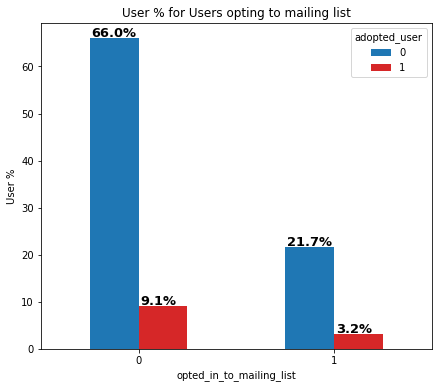

In [23]:
ax = (pd.crosstab(users.opted_in_to_mailing_list, users.adopted_user)*100/len(users)).plot(kind='bar', 
                                                                            color=('tab:blue','tab:red'), 
                                                                            figsize=(7,6))
plt.title('User % for Users opting to mailing list')
plt.ylabel('User %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

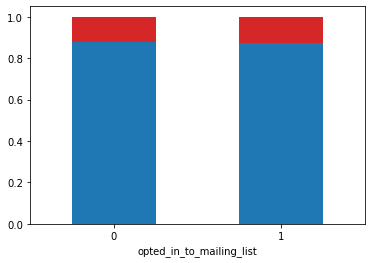

In [24]:
pd.crosstab(users.opted_in_to_mailing_list, users.adopted_user).apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', 
                                                                                     color=('tab:blue','tab:red'), 
                                                                                     stacked=True,
                                                                                     legend=False)
plt.xticks(rotation='horizontal')
plt.show()

- **There is a very small difference. Users opting to mailing list or not dosen't indicate if they become adopted users.**

### Enabled for Marketing Drip:

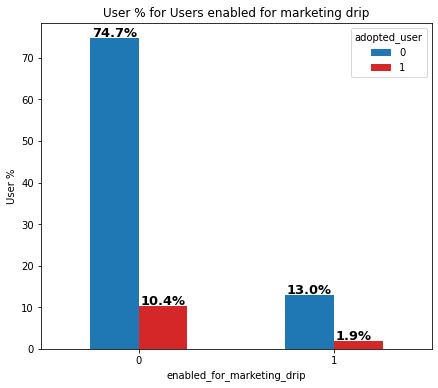

In [25]:
ax = (pd.crosstab(users.enabled_for_marketing_drip, users.adopted_user)*100/len(users)).plot(kind='bar', 
                                                                            color=('tab:blue','tab:red'), 
                                                                            figsize=(7,6))
plt.title('User % for Users enabled for marketing drip')
plt.ylabel('User %')
plt.xticks(rotation='horizontal')
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(str(round(height, 1))+'%', (x + 0.01, y + height + 0.3), fontsize=13, weight='bold')

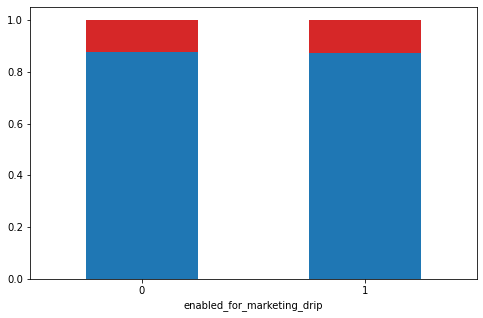

In [26]:
pd.crosstab(users.enabled_for_marketing_drip, users.adopted_user).apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', 
                                                                                     color=('tab:blue','tab:red'), 
                                                                                     stacked=True, 
                                                                                     figsize=(8,5),
                                                                                     legend=False)
plt.xticks(rotation='horizontal')
plt.show()

- **Users on the regular marketing email drip or not dosen't indicate clearly if they become adopted users.**

### Creation Time:

In [27]:
#Let's create user count by year-month and adopted user 

b = users.groupby([users.creation_time.dt.strftime('%Y-%m'), 'adopted_user']).count()
b = b.iloc[:,0].reset_index().rename(columns={'object_id': 'user_count'})
b.head(10)

,creation_time,adopted_user,user_count
0,2012-05,0,15
1,2012-05,1,1
2,2012-06,0,335
3,2012-06,1,66
4,2012-07,0,332
5,2012-07,1,55
6,2012-08,0,305
7,2012-08,1,60
8,2012-09,0,346
9,2012-09,1,63


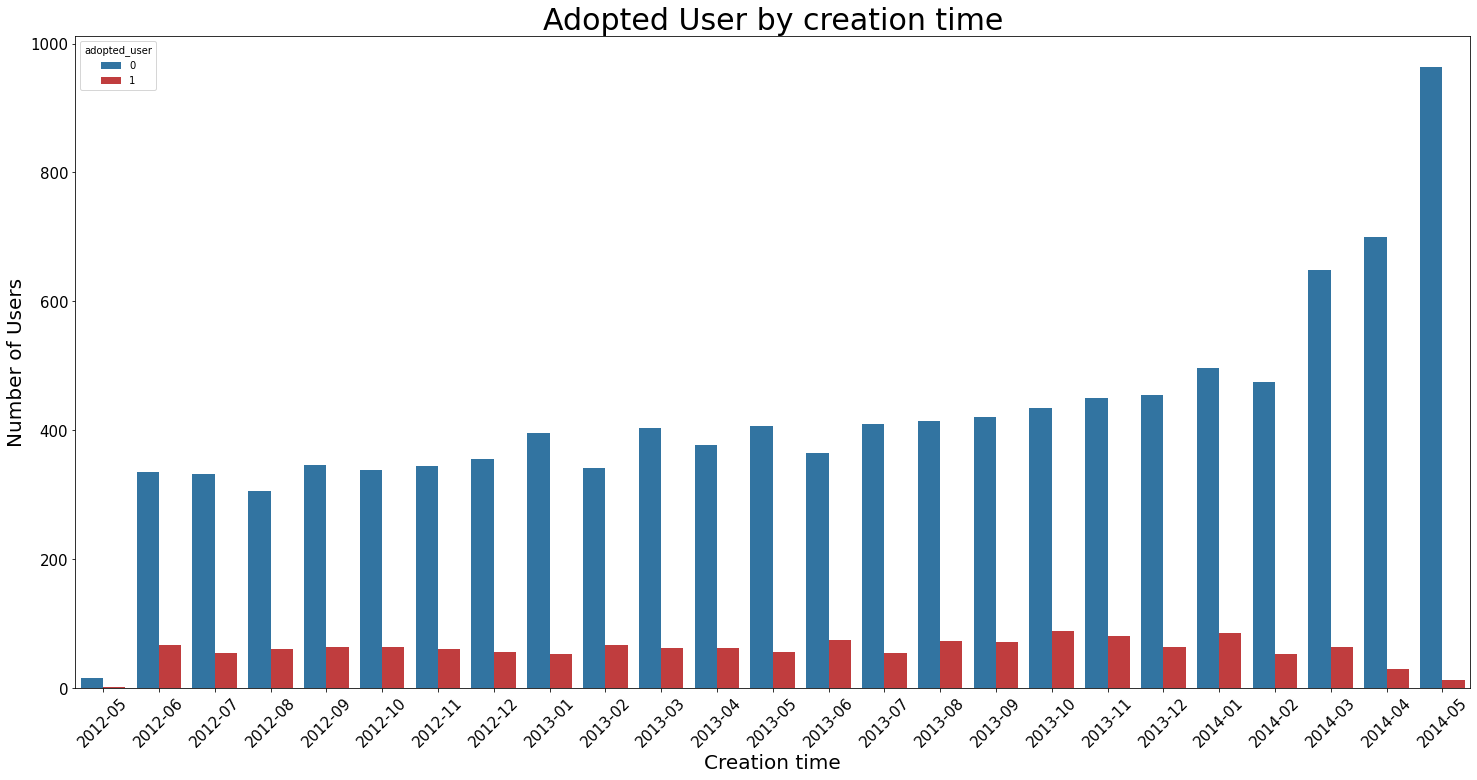

In [28]:
plt.figure(figsize=(25,12))
sns.barplot(x='creation_time', y='user_count', hue='adopted_user', data=b, palette=['tab:blue','tab:red'])
plt.title('Adopted User by creation time', fontsize=30)
plt.ylabel('Number of Users', fontsize=20)
plt.xlabel('Creation time', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- **Users who signed up not recently are likely become an adopted user.**

### Last Session login:

In [29]:
#Let's create user count by year-month and adopted user 

a = users.groupby([users.last_session_creation_time.dt.strftime('%Y-%m'), 'adopted_user']).count()
a = a.iloc[:,0].reset_index().rename(columns={'object_id': 'user_count'})
a.head(10)

,last_session_creation_time,adopted_user,user_count
0,2012-05,0,2
1,2012-06,0,200
2,2012-07,0,215
3,2012-07,1,3
4,2012-08,0,197
5,2012-08,1,2
6,2012-09,0,229
7,2012-09,1,7
8,2012-10,0,246
9,2012-10,1,5


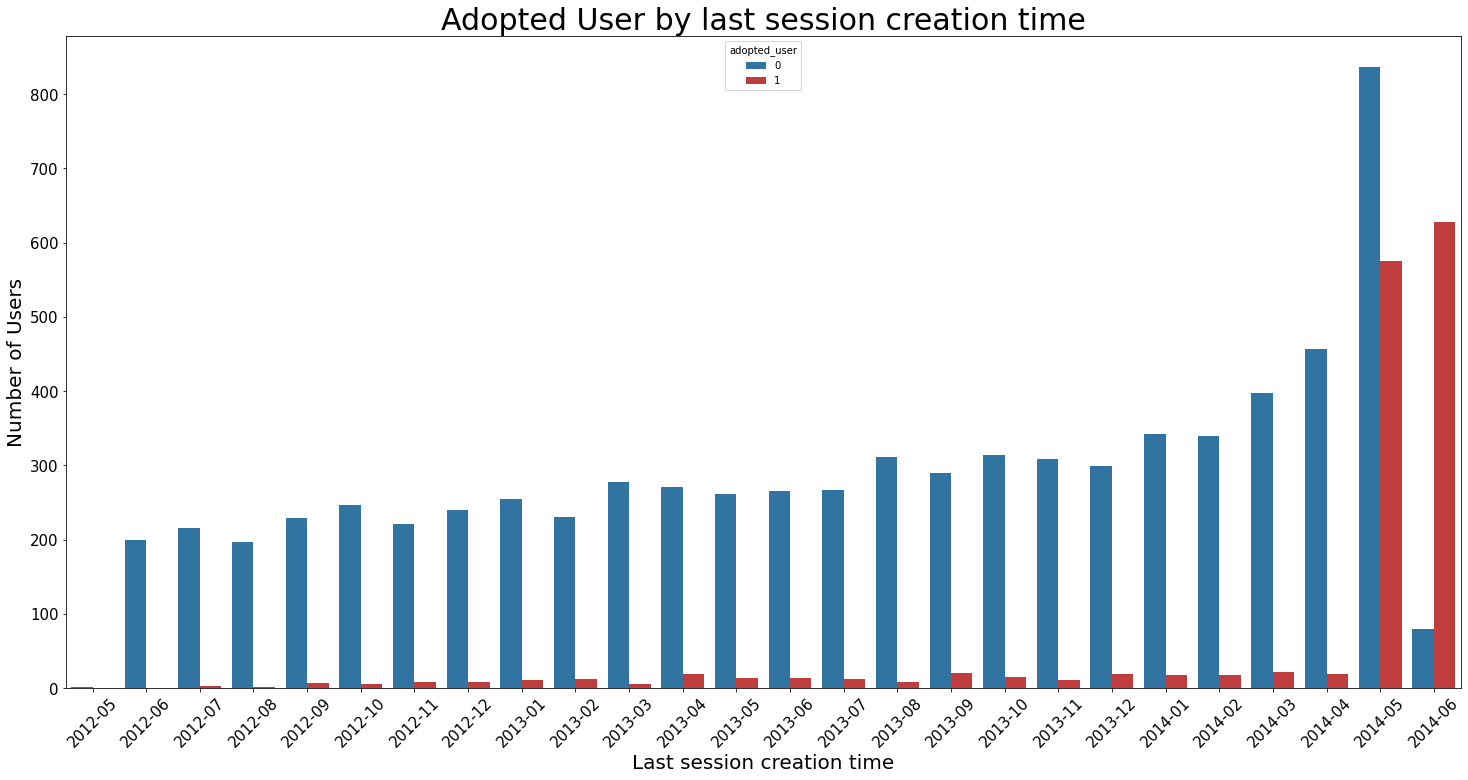

In [30]:
plt.figure(figsize=(25,12))
sns.barplot(x='last_session_creation_time', y='user_count', hue='adopted_user', data=a, palette=['tab:blue','tab:red'])
plt.title('Adopted User by last session creation time', fontsize=30)
plt.ylabel('Number of Users', fontsize=20)
plt.xlabel('Last session creation time', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- **Users who logged in very recently are most likely to become adopted.**
- **Measures adopted in the month of May and June led to a huge conversion of users to an adopted user. This can be implemented in the future too.**

### Organization:

In [31]:
users.org_id.nunique()

417

In [32]:
#Let's check for only the first 100 values
c = users.groupby(['org_id', 'adopted_user']).count()[0:100]
c = c.iloc[:,0].reset_index().rename(columns={'object_id': 'user_count'})
c.head(10)

,org_id,adopted_user,user_count
0,0,0,308
1,0,1,11
2,1,0,220
3,1,1,13
4,2,0,187
5,2,1,14
6,3,0,154
7,3,1,14
8,4,0,145
9,4,1,14


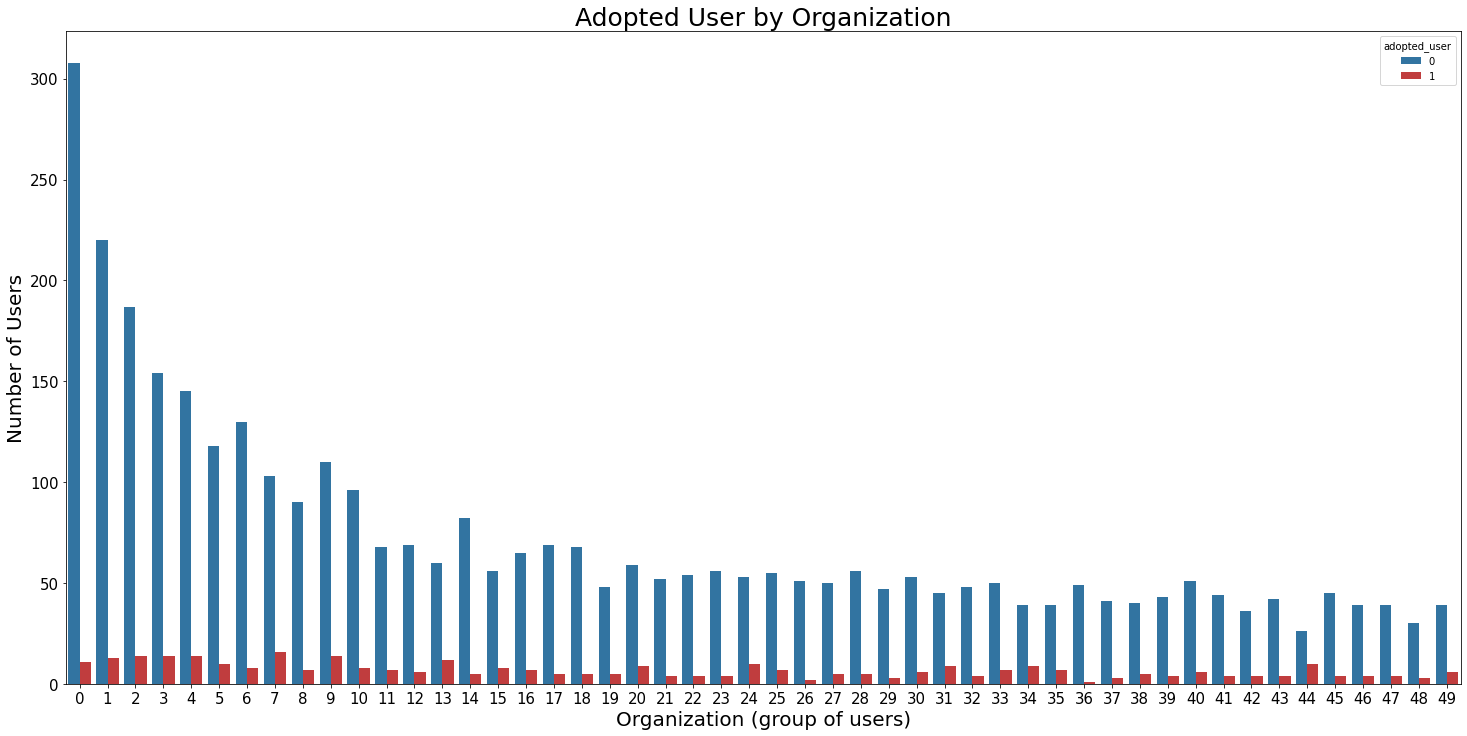

In [33]:
plt.figure(figsize=(25,12))
sns.barplot(x='org_id', y='user_count', hue='adopted_user', data=c, palette=['tab:blue','tab:red'])
plt.title('Adopted User by Organization', fontsize=25)
plt.ylabel('Number of Users', fontsize=20)
plt.xlabel('Organization (group of users)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- **Users working in small organizations are more likely to become adopted users.**

### Correlation Matrix:

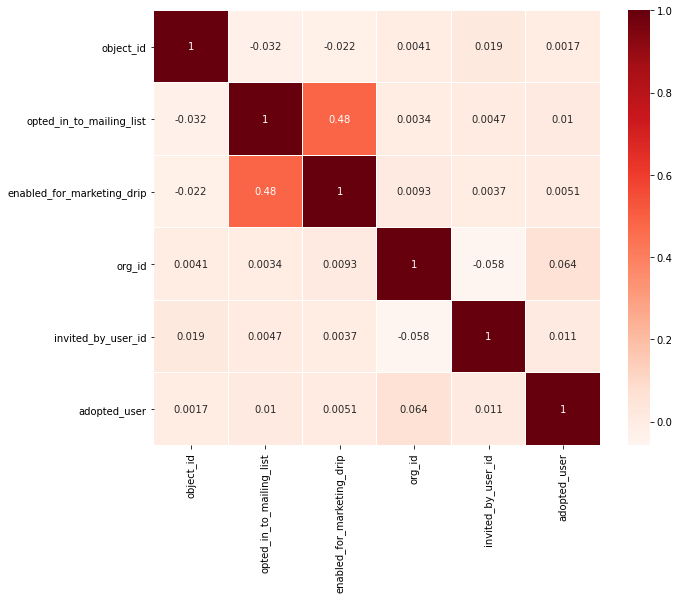

In [34]:
#Correlation matrix

plt.figure(figsize=(10,8))
sns.heatmap(users.corr(), annot=True, linewidths=0.1, cmap='Reds')

## Feature Engineering

In [35]:
users = users.set_index('object_id')

In [36]:
users = users.drop('name', axis=1)
users = users.drop('invited_by_user_id', axis=1)

In [37]:
users['creation_time_month'] = users['creation_time'].apply(lambda x: x.month)
users['creation_time_year'] = users['creation_time'].apply(lambda x: x.year)

In [38]:
users = users.drop('creation_time', axis=1)

In [39]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['last_session_creation_time'].mean())

users['last_session_creation_time_month'] = users['last_session_creation_time'].apply(lambda x: x.month)
users['last_session_creation_time_year'] = users['last_session_creation_time'].apply(lambda x: x.year)

In [40]:
users = users.drop('last_session_creation_time', axis=1)

In [41]:
users.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_time_month,creation_time_year,last_session_creation_time_month,last_session_creation_time_year
object_id,,,,,,,,,,
1,yahoo,GUEST_INVITE,1,0,11,0,4,2014,4,2014
2,gustr,ORG_INVITE,0,0,1,1,11,2013,3,2014
3,gustr,ORG_INVITE,0,0,94,0,3,2013,3,2013
4,yahoo,GUEST_INVITE,0,0,1,0,5,2013,5,2013
5,yahoo,GUEST_INVITE,0,0,193,0,1,2013,1,2013


## Machine Learning

### Label Encoding and Scaling:

In [42]:
# Label Encoding categorical columns

def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

users = users.apply(lambda x: object_to_int(x))

# Scaling numercial columns
std = StandardScaler()
scaled = pd.DataFrame(std.fit_transform(users[['org_id']]), columns=['org_id'])

users = users.drop(columns=['org_id'], axis=1)
users = users.reset_index().merge(scaled, left_index=True, right_index=True, how="left").set_index('object_id')
users.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_time_month,creation_time_year,last_session_creation_time_month,last_session_creation_time_year,org_id
object_id,,,,,,,,,,
1,6,0,1,0,0,4,2014,4,2014,-1.055082
2,2,1,0,0,1,11,2013,3,2014,-1.135694
3,2,1,0,0,0,3,2013,3,2013,-0.386006
4,6,0,0,0,0,5,2013,5,2013,-1.135694
5,6,0,0,0,0,1,2013,1,2013,0.412050


### Model Building:

In [66]:
X = users.drop('adopted_user', axis=1)
y = users['adopted_user']

In [67]:
# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 46)

In [68]:
classifiers = [['Logistic Regression :', LogisticRegression()],
               ['K Neighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['Decision Tree :',DecisionTreeClassifier()],
               ['Random Forest :',RandomForestClassifier()],
               ['Gradient Boosting :',GradientBoostingClassifier()]]

for name, classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(name, accuracy_score(y_test, predictions))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression : 0.9391666666666667
K Neighbours : 0.9620833333333333
SVM : 0.88625
Decision Tree : 0.9620833333333333
Random Forest : 0.9754166666666667
Gradient Boosting : 0.9741666666666666


In [69]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.9745833333333334

- **Our Random Forest Classifier model gives an accuracy of 97%.**

Text(0.5, 1.0, 'Feature Importance')

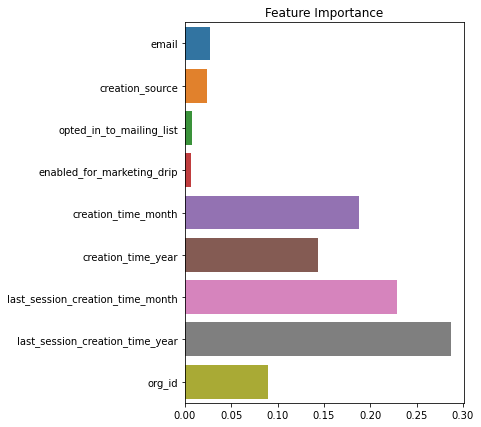

In [70]:
#Feature Importance

plt.figure(figsize=(5,7))
sns.barplot(clf.feature_importances_, X.columns)
plt.title('Feature Importance')

## Conclusion

- **last_session_creation_time is the most important feature when it comes to predicting adopted users.**
- **creation_time is the 2nd important feature to predict an adopted user.**
- **org_id is somewhat important.**
- **email and creation_source are able to predict an adopted user too but they are less important.**
- **The remaining features have close to zero importance and do not explain the target variable well.**